<a href="https://colab.research.google.com/github/wallinsonsilva/ciencia_de_dados_covid/blob/master/AnaliseApresentacaoDadosCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Este Colab tem como propósito explorar, analisar e apresentar os dados de contágio e óbitos por Covid-19 no estado do Rio Grande do Norte, e relacionar tais ocorrêsncias com fatores socioeconômicos.

Após as análises feitas identificamos as variáveis que mais agregaram valor a este trabalho e realizamos os seguintes relacionamentos:
- CIR's (Regiões de Saúde do RN) x Porcentagem de Óbitos.
- (Riqueza e Probreza) x Taxa de Contágia da População por Município;
- (Riqueza e Probreza) x Taxa de Óbitos da População por Município;
- (IDHM e GeoSES) x Taxa de Contágia da População por Município;
- (IDHM e GeoSES) x Taxa de Óbitos da População por Município;

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import plotly.express as px
sns.set()
import warnings
warnings.filterwarnings("ignore")

O dataset utilizado para este trabalho é o resultado do join dos datasets de histórico de casos de Covid-19 no Brasil (apenas os dados do RN foram utilizados), GeoSES, Dados socioeconômicos do IBGE (2017) e Regiões de Saúde do Rio Grande do Norte (confecção manual).

In [118]:
#Lendo o arquivo do Git, mas o arquivo está sendo gerado em um outro colab.
dados = pd.read_csv('https://raw.githubusercontent.com/wallinsonsilva/ciencia_de_dados_covid/master/ET_dados_casos_mun_reg_igbe_geoses.csv')
dados.head()

,codmun,municipio,codRegiaoSaude,nomeRegiaoSaude,populacaoTCU2019,casosAcumulado,obitosAcumulado,porcentagem_casos_hab,porcentagem_obitos_casos,CIR,CodRegiao,Sede,Região de Saúde,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Código Município,Código Município Completo,Municipio,CodMunIBGE,Código,Área Territorial - km²,População estimada - pessoas,Densidade demográfica - hab/km²,Escolarização 6 a 14 anos,IDHM - Índice de desenvolvimento humano municipal,Mortalidade infantil - óbitos por mil nascidos vivos,Receitas realizadas - R$ (×1000),Despesas empenhadas - R$ (×1000) [2017],PIB per capita - R$,v0002_codigo_do_municipio,GeoSES,educação,mobilidade,pobreza,privacao_material,riqueza,renda,segregacao
0,240010,Acari,24004,4ª REGIAO DE SAUDE - CAICO,11136,61,3,0.005478,0.049180,1,24001,São José de Mipibu,Litoral Sul/Agreste,4,Leste Potiguar,19,Litoral Sul,1206,2401206,Arês,240010,2401206,115.407,14306,111.89,97.8,0.606,21.62,37742.71317,36142.88627,25320.79,2401206,-0.647302,72.117813,0,64.150707,11.024704,0.264573,1181.152307,0.063689
1,240020,Açu,24008,8ª REGIAO DE SAUDE - ACU,58017,1167,51,0.020115,0.043702,1,24001,São José de Mipibu,Litoral Sul/Agreste,4,Leste Potiguar,19,Litoral Sul,1404,2401404,Baía Formosa,240020,2401404,247.484,9271,34.90,98.1,0.609,15.75,23656.20599,22372.78323,14474.61,2401404,-0.562420,71.767885,0,60.811667,17.638927,0.991362,1318.135729,0.075266
2,240030,Afonso Bezerra,24003,3ª REGIAO DE SAUDE - JOAO CAMARA,11035,101,6,0.009153,0.059406,1,24001,São José de Mipibu,Litoral Sul/Agreste,2,Central Potiguar,8,Macau,1859,2401859,Brejinho,240030,2401859,225.633,6549,31.74,97.3,0.574,12.35,14708.53170,12637.13207,10478.59,2401859,-0.749169,77.517295,0,66.610927,5.009073,0.323988,1119.490015,0.037168
3,240040,Água Nova,24006,6ª REGIAO DE SAUDE - PAU DOS FERROS,3252,20,0,0.006150,0.000000,1,24001,São José de Mipibu,Litoral Sul/Agreste,1,Oeste Potiguar,2,Chapada do Apodi,2303,2402303,Canguaretama,240040,2402303,1095.803,20493,17.88,98.7,0.638,4.10,42320.08649,38889.63622,14679.06,2402303,-0.499886,69.243226,0,59.029826,10.473723,0.892660,1233.537515,0.097144
4,240050,Alexandria,24006,6ª REGIAO DE SAUDE - PAU DOS FERROS,13577,44,4,0.003241,0.090909,1,24001,São José de Mipibu,Litoral Sul/Agreste,4,Leste Potiguar,18,Natal,3608,2403608,Espírito Santo,240050,2403608,140.639,28583,176.03,96.6,0.660,15.82,80913.26618,72936.48877,13667.37,2403608,-0.522203,67.440687,0,53.406674,17.139449,0.911317,1593.480555,0.038111


In [119]:
#Coluna e tipo de dados do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 40 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   codmun                                                167 non-null    int64  
 1   municipio                                             167 non-null    object 
 2   codRegiaoSaude                                        167 non-null    int64  
 3   nomeRegiaoSaude                                       167 non-null    object 
 4   populacaoTCU2019                                      167 non-null    int64  
 5   casosAcumulado                                        167 non-null    int64  
 6   obitosAcumulado                                       167 non-null    int64  
 7   porcentagem_casos_hab                                 167 non-null    float64
 8   porcentagem_obitos_casos                              167 no

Text(0.5, 0, 'Distribuição da Quantidade de Casos Por Municipio')

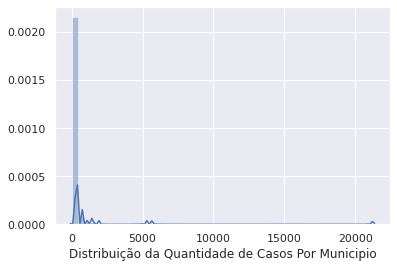

In [120]:
#Distribuição da quantidade de casos por município. Boa parte municípios apresentam uma quantidade de casos semelhantes.
sns.distplot(dados["casosAcumulado"])
plt.xlabel('Distribuição da Quantidade de Casos Por Municipio')

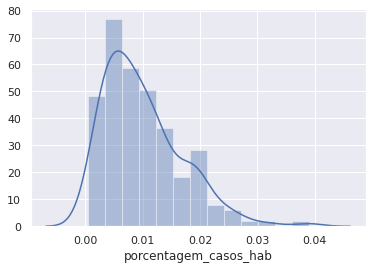

In [121]:
sns.distplot(dados["porcentagem_casos_hab"])

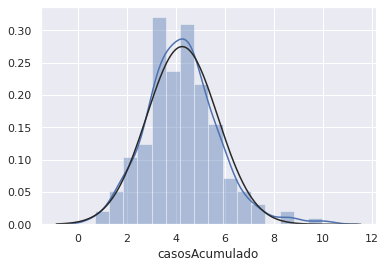

In [122]:
#Logaritimo dos casosAcumulado e a exibição dos dados de forma normalizada
casos_log = np.log(dados["casosAcumulado"])
sns.distplot(casos_log,fit=norm)

### Correlação entre o tamanho da população e a quantidade de casos acumulados

In [123]:
populacao_casoacumulado.corr()

,pobreza,porcent_pop_contagiada
pobreza,1.000000,0.088043
porcent_pop_contagiada,0.088043,1.000000


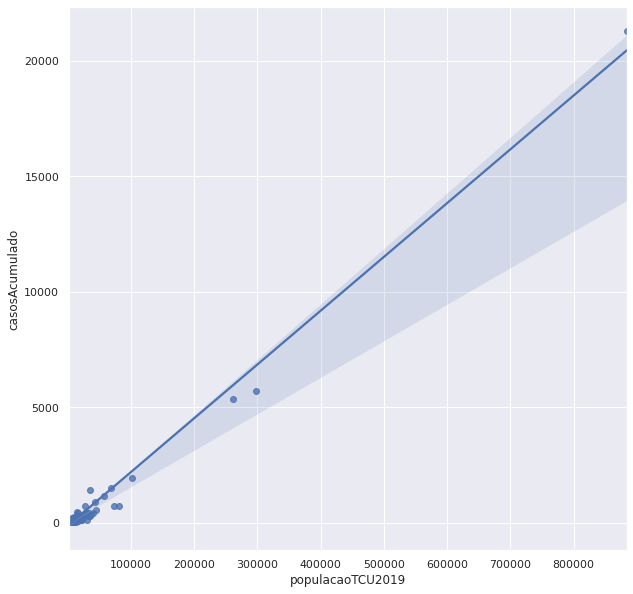

In [124]:
#Relacionamento entre o tamanho da população e a quantidade de casos.
populacao_casoacumulado = dados.loc[:,['populacaoTCU2019','casosAcumulado']]
plt.figure(figsize=(10, 10))
sns.regplot(x="populacaoTCU2019", y="casosAcumulado", data=populacao_casoacumulado,label="Relação da Quantidade de Casos com o Tamanho da População")
plt.show()

## Regiões de Saúde do RN com maior taxa de óbitos.

In [125]:
#Quantidade de casos e óbitos por região de saúde do RN
casos_regiao = pd.pivot_table(dados, index=['codRegiaoSaude','nomeRegiaoSaude'],values=['casosAcumulado','obitosAcumulado'],aggfunc=np.sum)
casos_regiao['porcentagem_obito'] = (casos_regiao['obitosAcumulado'] / casos_regiao['casosAcumulado'])*100
casos_regiao = casos_regiao.reset_index()
casos_regiao

,codRegiaoSaude,nomeRegiaoSaude,casosAcumulado,obitosAcumulado,porcentagem_obito
0,24001,1ª REGIAO DE SAUDE - SAO JOSE DE MIPIBU,4526,133,2.938577
1,24002,2ª REGIAO DE SAUDE - MOSSORO,9443,308,3.261675
2,24003,3ª REGIAO DE SAUDE - JOAO CAMARA,3762,133,3.535354
3,24004,4ª REGIAO DE SAUDE - CAICO,3726,73,1.959206
4,24005,5ª REGIAO DE SAUDE - SANTA CRUZ,2120,60,2.830189
5,24006,6ª REGIAO DE SAUDE - PAU DOS FERROS,1030,36,3.495146
6,24007,7ª REGIAO DE SAUDE - METROPOLITANA,29774,1184,3.976624
7,24008,8ª REGIAO DE SAUDE - ACU,2691,109,4.050539


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

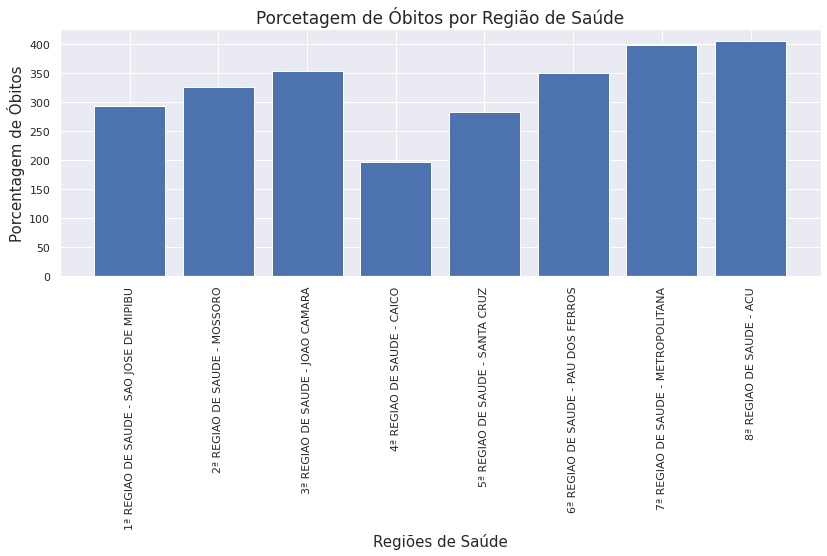

In [126]:
plt.figure(figsize=(30,10))
plt.subplot(221)
plt.bar(casos_regiao['nomeRegiaoSaude'],casos_regiao['porcentagem_obito']*100)
plt.title('Porcetagem de Óbitos por Região de Saúde', fontsize=17)
plt.ylabel('Porcentagem de Óbitos', fontsize=15)
plt.xlabel('Regiões de Saúde', fontsize=15)
plt.xticks(rotation=90)

In [127]:
#Agrupamento dos dados de cada um dos municípios e com informações relevantes do Dataset do GeoSES
principais_dados = dados[['codmun','municipio','CIR','populacaoTCU2019','casosAcumulado','obitosAcumulado',
                                              'IDHM - Índice de desenvolvimento humano municipal',
                                              'PIB per capita - R$','Código Município Completo','GeoSES',
                                              'educação','mobilidade','pobreza','privacao_material',
                                              'riqueza','renda','segregacao']]
principais_dados['porcentagem_obito'] = (principais_dados['obitosAcumulado'] / principais_dados['casosAcumulado']) * 100
principais_dados['porcent_pop_contagiada'] = (principais_dados['casosAcumulado'] / principais_dados['populacaoTCU2019']) * 100
principais_dados.rename(columns={'IDHM - Índice de desenvolvimento humano municipal':'IDHM'}, inplace=True)
principais_dados

,codmun,municipio,CIR,populacaoTCU2019,casosAcumulado,obitosAcumulado,IDHM,PIB per capita - R$,Código Município Completo,GeoSES,educação,mobilidade,pobreza,privacao_material,riqueza,renda,segregacao,porcentagem_obito,porcent_pop_contagiada
0,240010,Acari,1,11136,61,3,0.606,25320.79,2401206,-0.647302,72.117813,0,64.150707,11.024704,0.264573,1181.152307,0.063689,4.918033,0.547773
1,240020,Açu,1,58017,1167,51,0.609,14474.61,2401404,-0.562420,71.767885,0,60.811667,17.638927,0.991362,1318.135729,0.075266,4.370180,2.011479
2,240030,Afonso Bezerra,1,11035,101,6,0.574,10478.59,2401859,-0.749169,77.517295,0,66.610927,5.009073,0.323988,1119.490015,0.037168,5.940594,0.915270
3,240040,Água Nova,1,3252,20,0,0.638,14679.06,2402303,-0.499886,69.243226,0,59.029826,10.473723,0.892660,1233.537515,0.097144,0.000000,0.615006
4,240050,Alexandria,1,13577,44,4,0.660,13667.37,2403608,-0.522203,67.440687,0,53.406674,17.139449,0.911317,1593.480555,0.038111,9.090909,0.324077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,241470,Várzea,8,5500,81,5,0.603,10548.49,2408706,-0.606017,71.114447,0,59.764848,9.802610,0.000000,1068.574330,0.073217,6.172840,1.472727
163,241475,Venha-Ver,8,4177,8,3,0.631,18855.95,2409902,-0.569204,70.796075,0,57.211424,7.556295,0.575122,1441.314729,0.037956,37.500000,0.191525
164,241480,Vera Cruz,8,12481,119,6,0.590,17319.28,2410256,-0.704905,76.726997,0,71.308266,9.362697,0.000000,966.006698,0.055905,5.042017,0.953449
165,241490,Viçosa,8,1718,9,0,0.611,8416.47,2412807,-0.539910,74.998318,0,59.881687,9.492865,0.580333,1145.827567,0.098561,0.000000,0.523865


In [128]:
#Seleção de dados
principais_dados = principais_dados[
                 ['codmun','municipio','IDHM','GeoSES','educação','pobreza','casosAcumulado','obitosAcumulado','privacao_material','riqueza','renda','segregacao','porcentagem_obito','porcent_pop_contagiada']
                 ]

## Relação de Riqueza e Pobreza com a Porcentagem de Contágio da População por Município

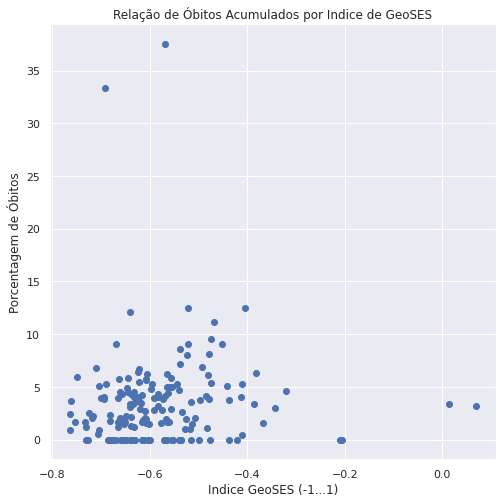

In [129]:
x = "GeoSES"
y = "porcentagem_obito"
populacao_casoacumulado = principais_dados.loc[:,[x,y]]
plt.figure(figsize=(8, 8))
plt.scatter(x=x, y=y, data=populacao_casoacumulado)
plt.xlabel("Indice GeoSES (-1...1)")
plt.ylabel("Porcentagem de Óbitos")
plt.title('Relação de Óbitos Acumulados por Indice de GeoSES')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada')

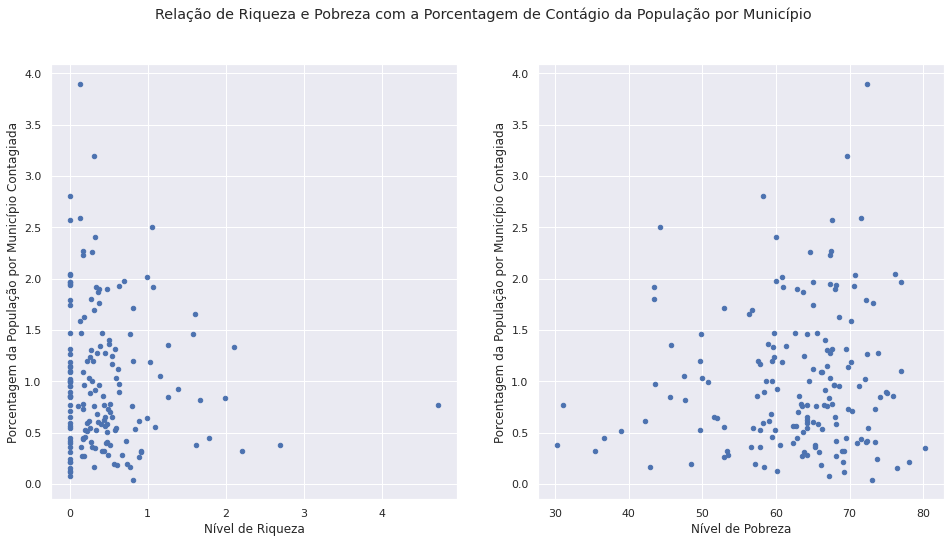

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [130]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação de Riqueza e Pobreza com a Porcentagem de Contágio da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "riqueza"
x2 = "pobreza"
y = "porcent_pop_contagiada"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Nível de Riqueza')
ax1.set_ylabel('Porcentagem da População por Município Contagiada')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Nível de Pobreza')
ax2.set_ylabel('Porcentagem da População por Município Contagiada')

In [131]:
fig = px.scatter(principais_dados, x="pobreza", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem da População Contagiada com Covid com o Indice de Pobreza",
                 labels={'pobreza':'Indice de Pobreza (Quanto maior pior)',
                         'porcent_pop_contagiada':'Porcentagem de habitantes contagiados por município',
                         'municipio':'Município'})
fig.show()

## Relação de Riqueza e Pobreza com a Porcentagem de Óbitos da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem de Óbito da População por Município Contagiada')

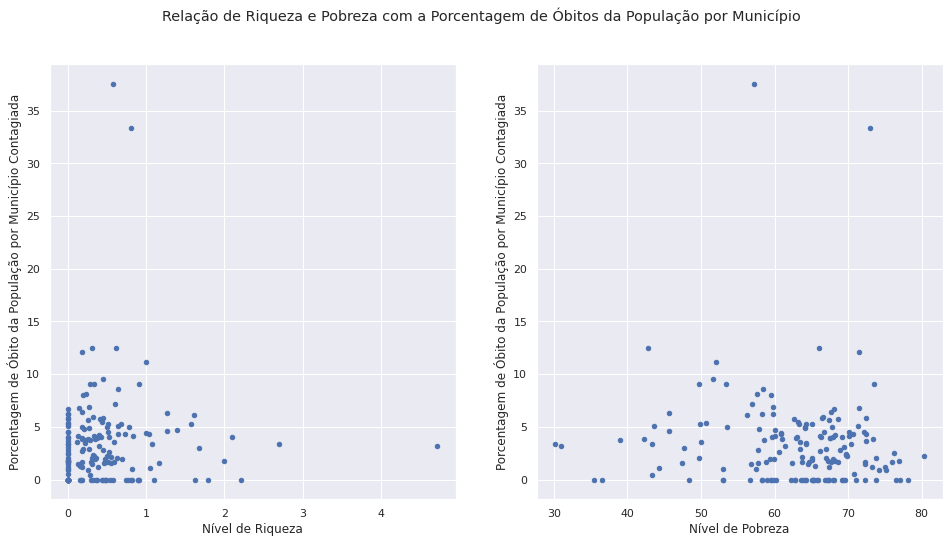

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [132]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação de Riqueza e Pobreza com a Porcentagem de Óbitos da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "riqueza"
x2 = "pobreza"
y = "porcentagem_obito"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Nível de Riqueza')
ax1.set_ylabel('Porcentagem de Óbito da População por Município Contagiada')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Nível de Pobreza')
ax2.set_ylabel('Porcentagem de Óbito da População por Município Contagiada')

In [133]:
fig = px.scatter(principais_dados, x="pobreza", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'pobreza':'Indice de Pobreza (Quanto maior pior)',
                         'porcentagem_obito':'Porcentagem de óbito por município',
                         'municipio':'Município'})
fig.show()

## Relação dos Indices de IDHM e GeoSES com a Porcentagem de Contágio da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada')

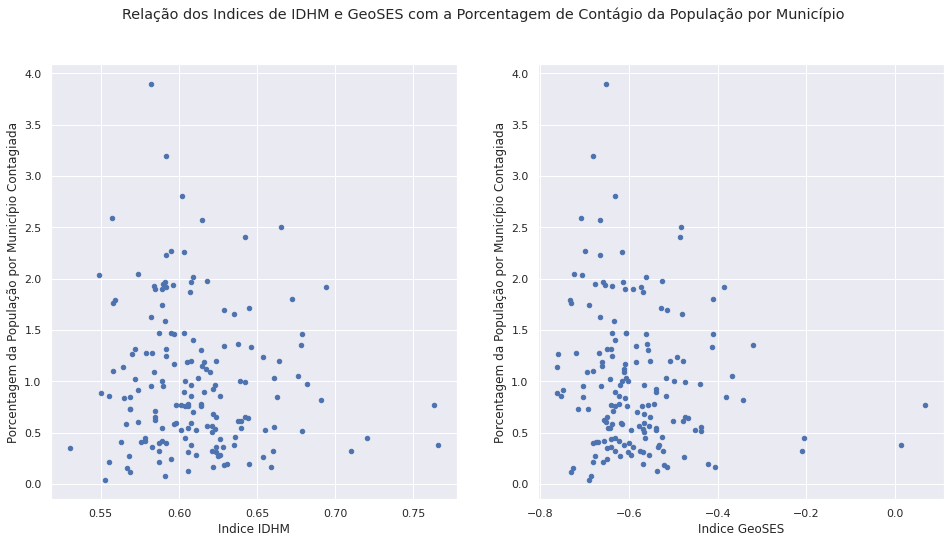

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [134]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação dos Indices de IDHM e GeoSES com a Porcentagem de Contágio da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "IDHM"
x2 = "GeoSES"
y = "porcent_pop_contagiada"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Indice IDHM')
ax1.set_ylabel('Porcentagem da População por Município Contagiada')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Indice GeoSES')
ax2.set_ylabel('Porcentagem da População por Município Contagiada')

In [135]:
fig = px.scatter(principais_dados, x="IDHM", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem de Contágio por Covid com o Indice de Pobreza",
                 labels={'IDHM':'IDHM - Indice de Desenvolvimento Humano - Municipal',
                         'porcent_pop_contagiada':'Porcentagem de óbito por município',
                         'municipio':'Município'})
fig.show()

In [136]:
fig = px.scatter(principais_dados, x="GeoSES", y="porcent_pop_contagiada", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'GeoSES':'GeoSES - Índice Socioeconômico do Contexto Geográfico para Estudos em Saúde',
                         'porcent_pop_contagiada':'Porcentagem de óbito por município',
                         'municipio':'Município'})
fig.show()

## Relação dos Indices de IDHM e GeoSES com a Porcentagem de Óbito da População por Município

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Porcentagem da População por Município Contagiada')

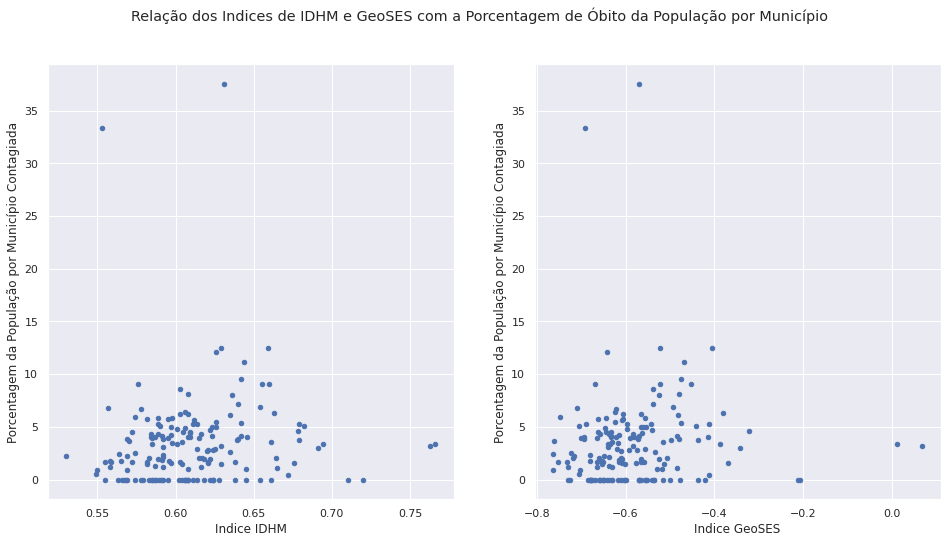

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [137]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fig.suptitle('Relação dos Indices de IDHM e GeoSES com a Porcentagem de Óbito da População por Município')

## Colunas do Dataset que serão utilizadas
x1 = "IDHM"
x2 = "GeoSES"
y = "porcentagem_obito"

populacao_casoacumulado = principais_dados.loc[:,[x1,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x1,y=y, ax=ax1)
ax1.set_xlabel('Indice IDHM')
ax1.set_ylabel('Porcentagem da População por Município Contagiada')


populacao_casoacumulado = principais_dados.loc[:,[x2,y]]
plt.figure(figsize=(15, 15))
populacao_casoacumulado.plot(kind='scatter',x=x2,y=y,ax=ax2)
ax2.set_xlabel('Indice GeoSES')
ax2.set_ylabel('Porcentagem da População por Município Contagiada')

In [138]:
fig = px.scatter(principais_dados, x="IDHM", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'IDHM':'IDHM - Indice de Desenvolvimento Humano - Municipal',
                         'porcentagem_obito':'Porcentagem de óbito por município',
                         'municipio':'Município'})
fig.show()

In [139]:
fig = px.scatter(principais_dados, x="GeoSES", y="porcentagem_obito", color='municipio',
                 title="Relaçao da Porcentagem de Óbitos por Covid com o Indice de Pobreza",
                 labels={'GeoSES':'GeoSES - Índice Socioeconômico do Contexto Geográfico para Estudos em Saúde',
                         'porcentagem_obito':'Porcentagem de óbito por município',
                         'municipio':'Município'})
fig.show()